In [1]:
from math import exp, log, pi, sqrt, cos, sin
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# univariate and multivariate normal probability density function
univariatepdf = stats.norm.pdf
multivariatepdf = stats.multivariate_normal.pdf

In [3]:
# dimension = dim
dim = 2

In [4]:
# parameters of the probability density function p
mixmus = [
    np.array([5.443438, 3.097593]),
    np.array([-5.592092, -2.150316])
]
mixsigmas = [
    np.array([[6.761966, 1.400297], [1.400297, 7.058602]]),
    np.array([[5.6483550, 0.4685284], [0.4685284, 9.2519292]])
]
mixweights = [
    0.465227,
    0.534773
]

In [5]:
# sample according to p
def sample(mixmus, mixsigmas, mixweights, n):
    indexes = np.random.choice(len(mixweights), size=n, p=mixweights)
    L = len(mixweights)
    A = np.zeros((n, L))
    for i, ix in enumerate(indexes):
        A[i, :] = stats.multivariate_normal.rvs(mixmus[ix], mixsigmas[ix])
    return A

In [6]:
# function f
def f(x):
    cov = np.eye(dim)
    mu = np.array([4,4])
    cov = np.eye(dim) * 8
    a = (np.sqrt(2*pi))**(dim) * multivariatepdf(x.ravel(), mu.ravel(), cov)
    mu = np.array([-4,-4])
    cov = np.eye(dim) * 8
    b = (np.sqrt(2*pi))**(dim) * multivariatepdf(x.ravel(), mu.ravel(), cov)
    mu = np.array([4,-4])
    cov = np.eye(dim) * 8
    c = (np.sqrt(2*pi))**(dim) * multivariatepdf(x.ravel(), mu.ravel(), cov)
    a1 = np.array([cos(s/1000) for s in x.ravel()])
    a2 = np.array([sin(s/1000) for s in x.ravel()]).transpose()
    return( 100 * (a + b + c +  np.dot(a1, a2)) )

In [7]:
# example, draw 6 points according to p
X = sample(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, n = 6)
for i in range(X.shape[0]):
    print(X[i,:], f(X[i,:]))

[ 7.1434914  2.7999726] 7.52955415905
[ 9.74922403  8.90476077] 2.21750002971
[-3.96821972 -5.47396419] 10.1751624068
[ 10.10334611   3.15472781] 2.54063858651
[ 7.45635868  0.22646492] 5.14223268684
[ 5.30095175  3.31617968] 12.1814182093


In [8]:
number = 80

samplepoints = sample(mixmus, mixsigmas, mixweights, number)
X = sorted(samplepoints[:,0])
Y = sorted(samplepoints[:,1])

X, Y = np.meshgrid(X, Y)
Z = np.zeros(X.shape)
s = 0
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        s += 1
        print("{0} / {1}".format(s, number*number), end = '\r')
        x = X[i][j]
        y = Y[i][j]
        Z[i][j] = f(np.array([x, y]))


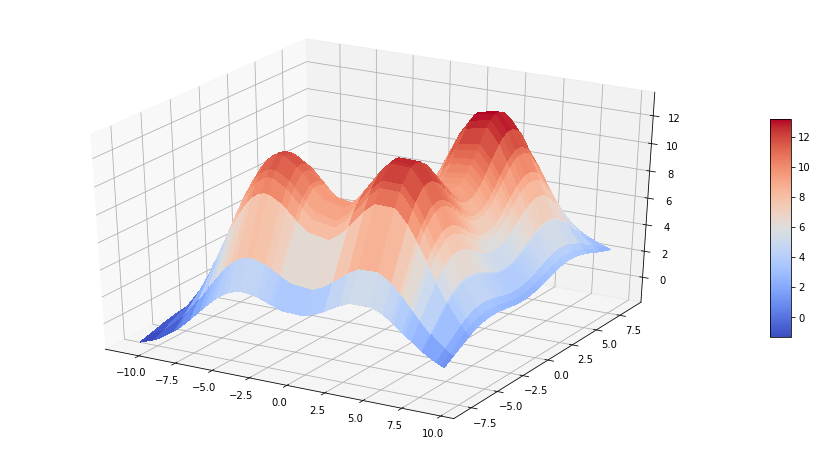

In [9]:
fig = plt.figure(figsize = (16, 8))
ax = fig.gca(projection = "3d")

plt.title(" ")
surf = ax.plot_surface(X, Y, Z, cmap = cm.coolwarm, linewidth = 0, antialiased = False)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

### Monte Carlo integration

In [10]:
n = 100 # number of points to draw at each iteration
m = 10 # number of iterations
I = []
for i in range(m):
    A = 0
    for j in range(n):
        weight = 1/n
        point = sample(mixmus, mixsigmas, mixweights, n = 1)
        A += weight*f(point)
    I.append(A)
print("Monte Carlo integration : ", sum(I)/len(I))

Monte Carlo integration :  6.44130184567


### Frank-Wolfe Bayesian Quadrature integration

In [11]:
n = 40 # number of points to draw
lambda_ = 1
sigma_ = 2

In [12]:
# reproducing kernel k (RKHS)
def kernel(a, b, lambda_, sigma_):
    cov = sigma_**2 * np.eye(dim)
    return( lambda_ * lambda_ * (np.sqrt(2*pi)*sigma_)**(dim) * multivariatepdf(a.ravel(), b.ravel(), cov) )

In [13]:
# one-dimensional mean map kernel
def simplemeanmapkernel(x, mu, sigma, lambda_, sigma_):
    cov = sigma_**2 * np.eye(dim)
    # np.linalg.det(sigma) = sigma
    # np.linalg.inv(sigma) = sigma
    return( lambda_ * lambda_ * (np.sqrt(2*pi)*sigma_)**(dim) * multivariatepdf(x.ravel(), mu.ravel(), sigma + cov) )
# two-dimensional mean map kernel
def mixturemeanmapkernel(x, mus, sigmas, mixweights, lambda_, sigma_):
    mixture = np.array([simplemeanmapkernel(x, mu1, sigma1, lambda_, sigma_) for mu1, sigma1 in zip(mus, sigmas)])
    return np.sum(mixweights * mixture)

In [14]:
# canonical feature map for a given x
def phi(x, lambda_, sigma_):
    def atom(a):
        return(kernel(a, x, lambda_, sigma_))
    return(atom)
# function to compute the successive g
def psi(rho, a, b):
    def g(x):
        return((1-rho) * a(x) + rho * b(x))
    return(g)

In [15]:
# define the model
model = "FWLSBQ"
# model = "FWBQ"

In [16]:
# start for rho, line-search
if model == "FWLSBQ":
    rho = [1/(i+1) for i in range(0, 1)]
    print("model is FWLSBQ")
elif model == "FWBQ":
    rho = [1/(i+1) for i in range(0, n)]
    print("model is FWBQ")
else:
    print("model has to be either FWLSBQ or FWBQ")

model is FWLSBQ


In [17]:
meanmapkernel = lambda x: mixturemeanmapkernel(x, mixmus, mixsigmas, mixweights, lambda_, sigma_)

In [18]:
# integral of the mean map kernel
def integralmeanmapkernel(mixmus, mixsigmas, mixweights, lambda_, sigma_):
    cov = sigma_**2 * np.eye(dim)
    L = len(mixweights)
    c = lambda_ * lambda_ * (np.sqrt(2*pi)*sigma_)**(dim)
    a = 0
    for i in range(L):
        for j in range(L):
            a = a + mixweights[i] * mixweights[j] * multivariatepdf(x = mixmus[i].ravel(), mean = mixmus[j].ravel(), cov = mixsigmas[i] + mixsigmas[j] + cov)
    return(c * a)

In [19]:
# step 1 // FW (Frank-Wolfe) algorithm

# store information in a dictionary
dico = {} # dictionnary to store at each iteration : point(i), weight(i), g(i)
i = 1
print("{0} / {1}".format(i, n), end = '\r')
W = [np.nan]
for l in range(1, i+1):
    w = 1
    for j in range(l+1, i+1):
        w = w * (1-rho[j-1])
    w = w * rho[l-1]
    W.append(w)
X = sample(mixmus, mixsigmas, mixweights, n = 1) # draw the first point randomly
dico[i] = {"point" : X[0], "weight" : W}
dico[i]["function"] = phi(dico[i]["point"], lambda_, sigma_)
g = phi(dico[i]["point"], lambda_, sigma_)
dico[i]["g"] = g

for i in range(2, n+1):

    print("{0} / {1}".format(i, n), end = '\r')

    # step1 ) computing a new point

    # T is the function to minimize
    def T(x, i, kernel, meanmapkernel):
        s = 0
        for j in range(1, i):
            w = dico[i-1]["weight"][j]
            c = dico[j]["point"]
            s = s + ( w * kernel(x, c, lambda_, sigma_) )
        s = s - meanmapkernel(x)
        return(s)

    # samplepoints to find the minimum among them
    if i > 0:
        samplepoints = sample(mixmus, mixsigmas, mixweights, n = 500)

    # start = clock()
    # find the minimum X
    Xmin = samplepoints[0]
    Tmin = T(x = Xmin, i = i, kernel = kernel, meanmapkernel = meanmapkernel)
    for X in samplepoints:
        t = T(x = X, i = i, kernel = kernel, meanmapkernel = meanmapkernel)
        if t < Tmin:
            Xmin = X
            Tmin = t
    X = Xmin
    # X = samplepoints[np.argmin([T(x, i, kernel, meanmapkernel) for x in samplepoints])]
    # end = clock()
    # print(end - start, "\n")

    # step 2 ) computing the weights for the next iteration

    if model == "FWLSBQ":
        # compute the matrix K
        K = np.zeros(shape = (i-1, i-1))
        for c in range(i-1):
            for d in range(i-1):
                Xc = dico[c+1]["point"]
                Xd = dico[d+1]["point"]
                K[c][d] = kernel(Xc, Xd, lambda_, sigma_)

        first = np.dot(np.dot([W[1:]], K), W[1:])
        second = 0
        weightedmeanmap = 0
        for r in range(1, i-1+1):
            point = dico[r]["point"] # point
            weight = W[r] # weight
            second += weight * kernel(point, X, lambda_, sigma_)
            weightedmeanmap += weight * meanmapkernel(point)
        numerator = first - second - weightedmeanmap + meanmapkernel(X)
        denominator = first - 2 * second + kernel(X, X, lambda_, sigma_)
        rho.append(float(numerator / denominator))

    W = [np.nan]
    for l in range(1, i+1):
        w = 1
        for j in range(l+1, i+1):
            w = w * (1-rho[j-1])
        w = w * rho[l-1]
        W.append(w)

    dico[i] = {"point" : X, "weight" : W}
    dico[i]["function"] = phi(dico[i]["point"], lambda_, sigma_)

    # step 3 ) computing the mean element
    g = psi(rho = rho[-1], a = g, b = dico[i]["function"])
    dico[i]["g"] = g


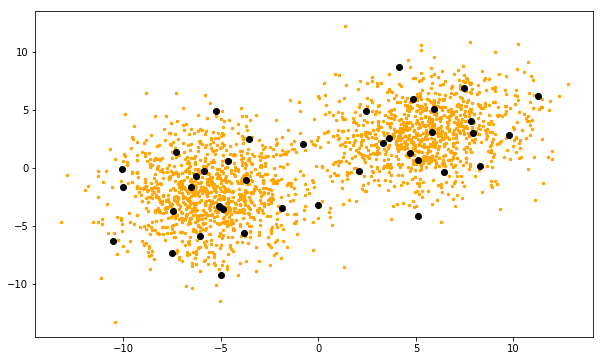

In [20]:
# plot the selected points and the distribution of the probability p

selectedpoints = np.matrix(data = np.zeros(n*dim).reshape(n, dim))

i = 0
for x in dico.items():
    selectedpoints[i,:] = x[1]["point"]
    i = i+1

selectedpoints = np.array(selectedpoints)

samplepoints = sample(mixmus, mixsigmas, mixweights, 2000)
X1 = samplepoints[:,0]
Y1 = samplepoints[:,1]
plt.rcParams["figure.figsize"] = (10, 6)
plt.scatter(X1, Y1, color = "orange", s = 6)
plt.scatter(selectedpoints[:,0], selectedpoints[:,1], color = "black")
plt.show()


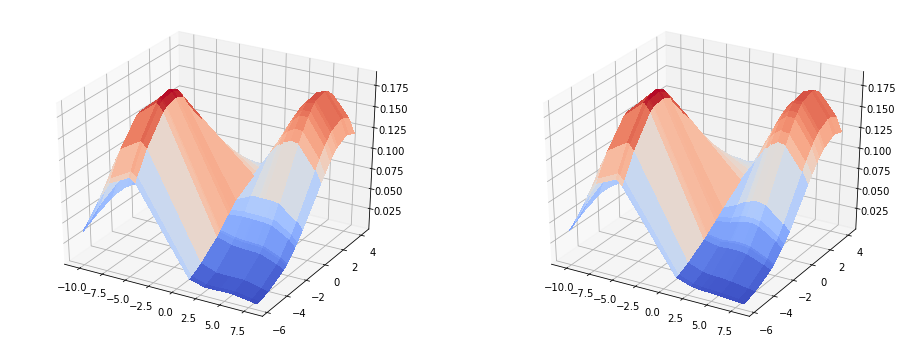

In [47]:
N = 20

fig = plt.figure(figsize=(16, 6))

samplepoints = sample(mixmus, mixsigmas, mixweights, N)
X = sorted(samplepoints[:,0])
Y = sorted(samplepoints[:,1])

ax = fig.add_subplot(1, 2, 1, projection='3d')
MX, MY = np.meshgrid(X, Y)
Z = np.zeros(MX.shape)
s = 0
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        s += 1
        print("{0} / {1}".format(s, N*N), end = '\r')
        x = MX[i][j]
        y = MY[i][j]
        Z[i][j] = g(np.array([x, y]))
surf = ax.plot_surface(MX, MY, Z, cmap = cm.coolwarm, linewidth = 0, antialiased = False)

# samplepoints = sample(mixmus, mixsigmas, mixweights, N)
# X = sorted(samplepoints[:,0])
# Y = sorted(samplepoints[:,1])

ax = fig.add_subplot(1, 2, 2, projection='3d')
MX, MY = np.meshgrid(X, Y)
Z = np.zeros(MX.shape)
s = 0
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        s += 1
        print("{0} / {1}".format(s, N*N), end = '\r')
        x = MX[i][j]
        y = MY[i][j]
        Z[i][j] = meanmapkernel(np.array([x, y]))
ax.plot_surface(MX, MY, Z, cmap = cm.coolwarm, linewidth = 0, antialiased = False)

plt.show()


In [48]:
# step 2 // BQ (Bayesian Quadrature) algorithm

# compute the vector Z
Z = np.zeros(shape = (n, 1))
for i in range(n):
    Xi = dico[i+1]["point"]
    Z[i][0] = meanmapkernel(Xi)

# compute the matrix K
K = np.zeros(shape = (n, n))
for i in range(n):
    for j in range(n):
        Xi = dico[i+1]["point"]
        Xj = dico[j+1]["point"]
        K[i][j] = kernel(Xi, Xj, lambda_, sigma_)
# compute the inverse of the matrix K
INVK = np.linalg.inv(K)

# Frank-Wolfe weights
WFW = W[1:]
print("sum of Frank-Wolfe weights = ", sum(WFW))

# Bayesian Quadrature weights
WBQ = np.dot(Z.transpose(), INVK)[0]
print("sum of Bayesian Quadrature weights = ", sum(WBQ))


sum of Frank-Wolfe weights =  1.0
sum of Bayesian Quadrature weights =  0.973612281581


In [49]:
# step 3 // posterior mean, equation (4) in the article

# compute the vector F
F = np.zeros(shape = (n, 1))
for i in range(n):
    Xi = dico[i+1]["point"]
    F[i][0] = f(Xi)

# compute the posterior mean
mean = np.float(np.dot(np.dot(Z.transpose(), INVK), F))

In [50]:
# step 4 // posterior variance, equation (5) in the article

variance1 = integralmeanmapkernel(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, lambda_ = lambda_, sigma_ = sigma_)
variance2 = np.float(np.dot(np.dot(Z.transpose(), INVK), Z))
variance = variance1 - variance2


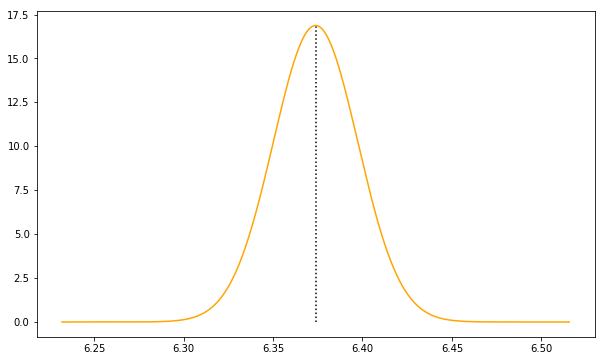

In [51]:
# step 5 // full posterior (normal distribution)

plt.rcParams["figure.figsize"] = (10, 6)
selectedpoints = np.array(selectedpoints)
X_ = np.linspace(start = mean-6*np.sqrt(variance), stop = mean+6*np.sqrt(variance), num = 1000)
Y_ = univariatepdf(x = X_, loc = mean, scale = np.sqrt(variance))
plt.plot(X_, Y_, color = "orange")
plt.vlines(x = mean, ymin = 0, ymax = max(Y_), color = "black", linestyles = "dotted")
plt.show()


In [52]:
# summary

print(" Monte Carlo integration \t \t \t =", float(sum(I)/len(I)), "\n",
"Frank-Wolfe integration \t \t \t =", float(np.float(np.dot(W[1:], F))), "\n",
"Frank-Wolfe Bayesian Quadrature integration \t =", float(mean))


 Monte Carlo integration 	 	 	 = 6.441301845672501 
 Frank-Wolfe integration 	 	 	 = 6.487261983566665 
 Frank-Wolfe Bayesian Quadrature integration 	 = 6.373769315998541


In [53]:
# compute the vector G
G = np.zeros(shape = (n, n))
for i in range(n):
    print("{0} / {1}".format(i+1, n+1), end = '\r')
    gi = dico[i+1]["g"]
    for j in range(i+1):
        G[j,i] = gi(dico[j+1]["point"])
print(G[:4,:4])

[[ 1.          0.49118466  0.35904254  0.29339547]
 [ 0.          0.50881681  0.34910512  0.2910631 ]
 [ 0.          0.          0.33754638  0.27330628]
 [ 0.          0.          0.          0.20663964]]


In [54]:
information = {}

# print(F.shape)
# print(Z.shape)
# print(K.shape)

start = 10

FWLS_mean = []
FWLSBQ_mean = []
FWLS_variance = []
FWLSBQ_variance = []

index = []
index.append(start)
x = start
while x < n+1:
    index.append(x)
    x += 5
    
I0 = index
    
for i in index:
    print("{0} / {1}".format(i, n), end = '\r')
    Gi = G[0:i,i-1].reshape(i, 1)
    Zi = Z[0:i,:]
    Fi = F[0:i,:]
    Ki = K[0:i,0:i]
    
    WeightsFW = dico[i]["weight"][1:]
    
    WeightsBQ = np.dot(Zi.transpose(), np.linalg.inv(Ki))
    
    MeanFW = np.float(np.dot(WeightsFW, Fi))
    
    MeanBQ = np.float(np.dot(WeightsBQ, Fi))
    
#     variance1 = integralmeanmapkernel(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, lambda_ = lambda_, sigma_ = sigma_)
#     variance2 = np.float(np.dot(WeightsFW, Gi))
#     variance = variance1 - variance2
    variance = np.sum(np.square(Gi - Zi))
    VarianceFW = abs(variance)

    
    variance1 = integralmeanmapkernel(mixmus = mixmus, mixsigmas = mixsigmas, mixweights = mixweights, lambda_ = lambda_, sigma_ = sigma_)
    variance2 = np.float(np.dot(WeightsBQ, Zi))
    variance = variance1 - variance2
    VarianceBQ = abs(variance)
    
    FWLS_mean.append(MeanFW)
    FWLSBQ_mean.append(MeanBQ)
    FWLS_variance.append(VarianceFW)
    FWLSBQ_variance.append(VarianceBQ)


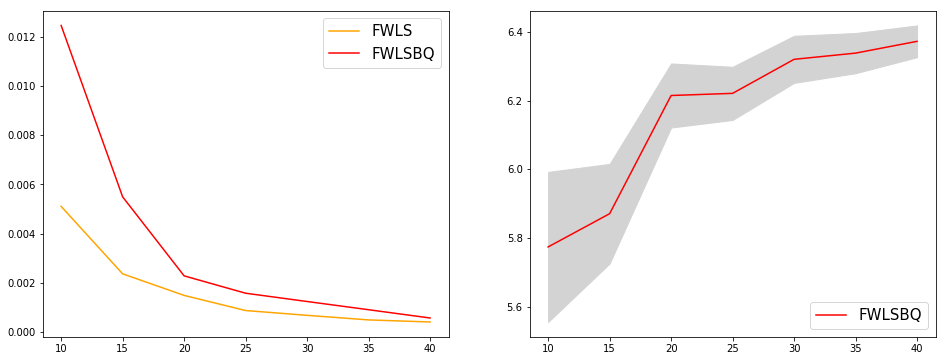

In [55]:
plt.rcParams["figure.figsize"] = (16, 6)

plt.subplot(1,2,1)
X1 = I0
Y1 = FWLS_variance
Y2 = FWLSBQ_variance

line1, = plt.plot(X1, Y1, color = "orange", label = "FWLS")
line2, = plt.plot(X1, Y2, color = "red", label = "FWLSBQ")
plt.legend(handles=[line1, line2], fontsize = 15, loc = 'upper right')

plt.subplot(1,2,2)
X0 = I0
Y0 = FWLSBQ_mean
Y01 = FWLSBQ_mean-1.96*np.sqrt(FWLSBQ_variance)
Y02 = FWLSBQ_mean+1.96*np.sqrt(FWLSBQ_variance)
line0, = plt.plot(X0, Y0, color = "red", label = "FWLSBQ")
plt.fill_between(I0, Y01, Y02, color = "lightgrey")
plt.legend(handles=[line0], fontsize = 15, loc = 'lower right')

plt.show()
